# DSCI Group 005 21 Project Report

### Introduction:

### Methods & Results:

In order to solve the predictive problem, we use both linear regression and K-nearest neighbors (KNN) regression. 
We start by loading packages, setting the seed, loading data, wrangling data and cleaning them.

In [6]:
library(tidyverse)
library(tidymodels)

# set seed
set.seed(100)

# read and tidy data
player_stats <- read_csv("player_stats.csv")
colnames(player_stats)[colnames(player_stats) == "Current Rank"] <- "Current_Rank"
player_stats <- player_stats |>
    separate(col = Current_Rank, into = c("current_rank", "other_rank"), sep = " ", convert = TRUE) |>
    filter(Seasons != " ") |>
    select(Seasons, current_rank)
head(player_stats)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Seasons,current_rank
<dbl>,<int>
14,178
2,236
11,183
5,31
1,307
1,232


We split the dataset into a training set and a testing set, and visualizing the data.

`geom_smooth()` using formula 'y ~ x'



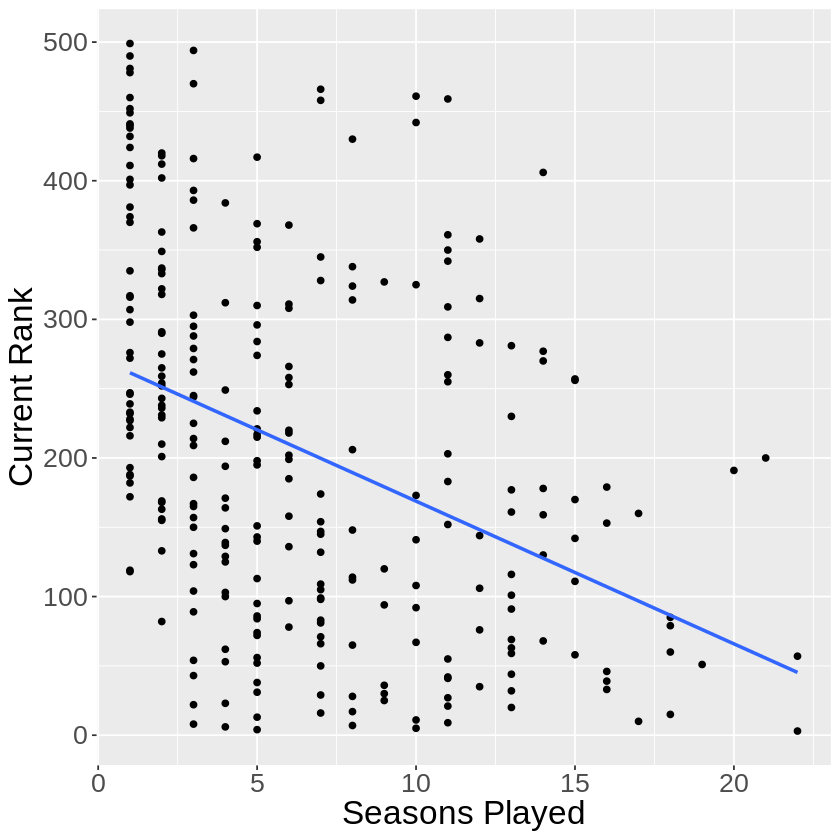

In [7]:
# split it into training and testing datasets
player_split <- initial_split(player_stats, prop = 0.75, strata = Seasons)
player_train <- training(player_split)
player_test <- testing(player_split)

# plot with best fit line
player_train_plot <- player_train |>
    ggplot(aes(x = Seasons, y = current_rank)) +
        geom_point() +
        xlab("Seasons Played") +
        ylab("Current Rank") +
        theme(text = element_text(size = 20)) +
        geom_smooth(method = "lm", se = FALSE)
player_train_plot

We start by using linear regression.

We create the model specification and recipe, and fit our simple linear regression model.

In [13]:
# linear regression
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")
lm_recipe <- recipe(Seasons ~., data = player_train)
player_lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_train)
player_lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  current_rank  
     9.53021      -0.01484  


Our coefficients are (intercept)= 9.53021 and (slope) = -0.01484
This means that the equation of the line of best fit is:

**Current Rank = 9.53021 - 0.01484 * Seasons Played**

Finally, we predict on the test data set to assess how well our model does:

In [14]:
player_lm_prediction <- player_lm_fit |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = Seasons, estimate = .pred) |>
    filter(.metric == "rmse")
player_lm_prediction

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.451144


Then, we use KNN regression to do the prediction.

First, we create a recipe for preprocessing our data.
Next we create a model specification for K-nearest neighbors regression.
Then we create a 5-fold cross-validation object, and put the recipe and model specification together in a workflow.

In [24]:
# KNN regression
player_recipe <- recipe(Seasons~., data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
player_vfold <- vfold_cv(player_train, v = 5, strata = Seasons)

Next we run cross-validation for a grid of numbers of neighbors ranging from 10 to 100. 

In [23]:
gridvals <- tibble(neighbors = seq(from = 10, to = 100, by = 10))
player_workflow <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(tuning_spec) |>
    tune_grid(resamples = player_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

We take the minimum RMSPE to find the best setting for the number of neighbors:

In [25]:
# show only the row of minimum RMSPE
player_min <- player_workflow |>
    filter(mean == min(mean))
player_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
30,rmse,standard,4.525353,5,0.1827257,Preprocessor1_Model03


The smallest RMSPE occurs when  K = 30.

Next, we need to evaulate how well our model might do at predicting on unseen data. We first re-train our KNN regression model on the entire training data set, using K = 30 neighbors. 
Then we will use predict to make predictions on the test data, and use the metrics function again to compute the summary of regression quality.

In [26]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("regression")

player_knn_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_train)

player_knn_prediction <- player_knn_fit |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = Seasons, estimate = .pred) |>
    filter(.metric == "rmse")

player_knn_prediction 

ERROR: [1m[33mError[39m in [1m[1m`bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 94) to match `..2` (size 95).


Our final model’s test error as assessed by RMSPE is ______.

### Discussion

### References